# Part 5 - Manually Updating the State

### 为什么手动更新状态？
这个还是和Human in loop相关。 P4时候我已经有了一个疑问，当条件发生时，人该如何控制流程。本节提供方法更新状态，让流程继续。 

### 本节重点知识是什么？



### 在产品化中要还需要哪些？


### 复习

API Reference:    
* [AIMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.ai.AIMessage.html)    
* [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html)


## Step1: 创建Graph `COPY` 

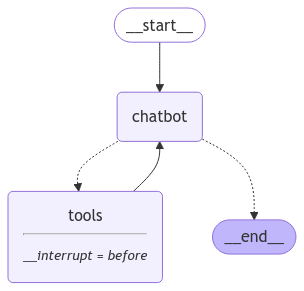

In [25]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph.state import StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

display(Image(graph.get_graph().draw_mermaid_png()))




In [26]:

user_input = "I'm learning langgraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, 
    config,
)

for e in events:
    if "messages" in e:
        e["messages"][-1].pretty_print()


snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_9s7ZfxbPU7IrhFxPJJbtwTGZ)
 Call ID: call_9s7ZfxbPU7IrhFxPJJbtwTGZ
  Args:
    query: langgraph programming language


In [27]:
## 重点： 

In [28]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "Langgraph is a library for building stateful, multi-actor application with LLMs"
)

new_messages = [
    ToolMessage(
        content=answer, 
        tool_call_id=existing_message.tool_calls[0]["id"]
    ),
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    config,
    {"messages": new_messages},
)

print("\n\nLast 2 messages")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

Langgraph is a library for building stateful, multi-actor application with LLMs


Last 2 messages
[ToolMessage(content='Langgraph is a library for building stateful, multi-actor application with LLMs', id='e4dc52c7-010c-42fa-a89b-9293d10b9e4d', tool_call_id='call_9s7ZfxbPU7IrhFxPJJbtwTGZ'), AIMessage(content='Langgraph is a library for building stateful, multi-actor application with LLMs', additional_kwargs={}, response_metadata={}, id='bc76f360-3d12-42bf-addd-5708cef1a02a')]
